In [1]:
import numpy as np
import foscat.scat_cov as sc
import matplotlib.pyplot as plt
import sys
import healpy as hp
import xarray as xr

In [2]:
dtotal=xr.open_zarr('/home/jmdeloui/DATA/test.zarr')
#dtotal=xr.open_zarr("https://data-fair2adapt.ifremer.fr/odysea/odysea.zarr").pipe(xdggs.decode)
dtotal

<xarray.Dataset> Size: 90MB
Dimensions:    (time: 24, depth: 8, latitude: 180, longitude: 324)
Coordinates:
  * depth      (depth) float32 32B 0.494 1.541 2.646 3.819 ... 6.441 7.93 9.573
  * latitude   (latitude) float32 720B 46.03 46.05 46.08 ... 50.94 50.97 51.0
  * longitude  (longitude) float32 1kB -7.999 -7.971 -7.944 ... 0.9456 0.9733
  * time       (time) datetime64[ns] 192B 2025-03-20 ... 2025-03-20T23:00:00
Data variables:
    thetao     (time, depth, latitude, longitude) float64 90MB dask.array<chunksize=(1, 1, 180, 324), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.8
    comment:      
    contact:      https://marine.copernicus.eu/contact
    institution:  NOW Systems (Spain)
    references:   http://marine.copernicus.eu/
    source:       NEMO3.6
    title:        Ocean 3D hourly mean fields for the Iberia-Biscay-Ireland (...

In [3]:
nside=1024
data = dtotal.thetao.compute().values[12,0,:,:]
longitude=np.tile(dtotal.longitude.compute().values,data.shape[0])
latitude=np.repeat(dtotal.latitude.compute().values,data.shape[1])
import foscat.HealSpline as HS

level=int(np.log2(nside)) # nside=128

sp = HS.heal_spline(level, gamma=1.5)

data=data.flatten()
longitude=360.0-longitude[~np.isnan(data)]
latitude=90.0-latitude[~np.isnan(data)]
data=data[~np.isnan(data)]

sp.Fit(data, np.deg2rad(latitude),np.deg2rad(longitude))
cell_ids=np.unique(hp.ang2pix(nside,np.deg2rad(latitude),np.deg2rad(longitude),nest=True))
t,p=hp.pix2ang(nside,cell_ids,nest=True)
data=sp.Transform(t,p)

Iter 000: residual = 2.453e+00
Iter 050: residual = 2.692e-01


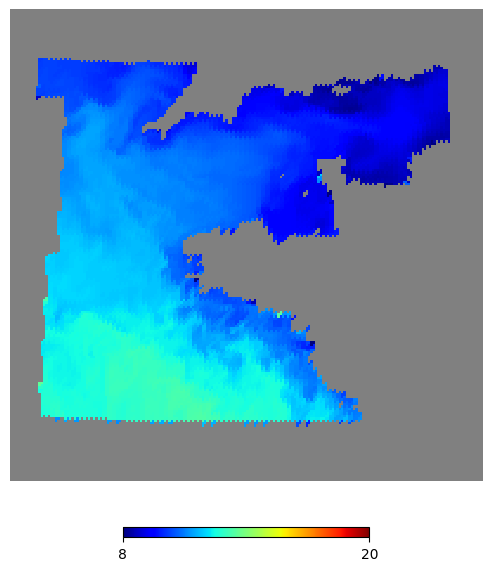

In [4]:
def plot_result(data,cell_ids,nside,hold=None,sub=None,title=None,
                unit=None,vmin=None,vmax=None,rot=[3.4,48.5],reso=2,norm=None):
    im=np.ones([12*nside**2])*hp.UNSEEN
    im[cell_ids]=data
    if vmin is None:
        vmin=data.min()
    if vmax is None:
        vmax=data.max()
    hp.gnomview(im,cmap='jet',nest=True,rot=rot,
                reso=reso,hold=hold,sub=sub,notext=True,title=title,
                unit=unit,min=vmin,max=vmax,norm=norm)

plot_result(data,cell_ids,nside,vmin=8,vmax=20)

In [17]:
import foscat.UNET as UNET

print(nside)
unet=UNET.UNET(in_nside=nside,cell_ids=cell_ids,chanlist=[8,8,16,32,64])

1024
N_layer  5
Initial chan 1 Npix=5722
Layer 0 Npix=5722
Layer 0 conv [1,8]
Layer 0 conv [8,8]
Layer 1 Npix=1542
Layer 1 conv [9,8]
Layer 1 conv [8,8]
Layer 2 Npix=429
Layer 2 conv [9,16]
Layer 2 conv [16,16]
Layer 3 Npix=131
Layer 3 conv [17,32]
Layer 3 conv [32,32]
Layer 4 Npix=41
Layer 4 conv [33,64]
Layer 4 conv [64,64]
Transpose Layer 0 Npix=41
Transpose Layer 0 conv [66,66]
Transpose Layer 0 conv [66,65]
Transpose Layer 1 Npix=131
Transpose Layer 1 conv [66,66]
Transpose Layer 1 conv [66,33]
Transpose Layer 2 Npix=429
Transpose Layer 2 conv [34,34]
Transpose Layer 2 conv [34,17]
Transpose Layer 3 Npix=1542
Transpose Layer 3 conv [18,18]
Transpose Layer 3 conv [18,9]
Transpose Layer 4 Npix=5722
Transpose Layer 4 conv [10,10]
Transpose Layer 4 conv [10,1]
Final chan 1 Npix=5722


In [18]:
f=sc.funct()
iref=data
c=cell_ids
l_nside=nside
for k in range(2):
    iref,c=f.ud_grade_2(iref,cell_ids=c,nside=l_nside)
    l_nside/=2
iref=f.up_grade(iref,nout=nside,cell_ids=c.cpu().numpy(),
                o_cell_ids=cell_ids,nside=l_nside)
    
ref=f.backend.bk_cast(data.reshape(1,1,data.shape[0]))
r=unet.eval(ref).detach()

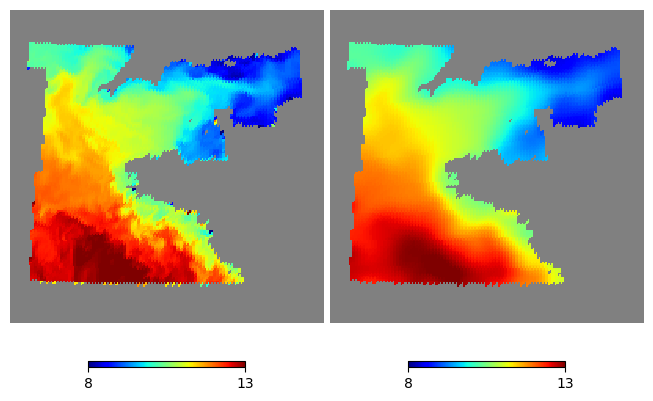

In [19]:
plot_result(data,cell_ids,nside,hold=False,sub=(1,2,1),vmin=8,vmax=13)
plot_result(iref.cpu().numpy(),cell_ids,nside,hold=False,sub=(1,2,2),vmin=8,vmax=13)

In [20]:
def The_loss(u,scat_operator,args):
    iref  = args[0]
    ref   = args[1]
    unet  = args[2]
    cell_ids= args[3]
    nside = args[4]

    unet.set_param(u)
    learn=unet.eval(iref)-ref
    '''
    #use the smaller scale inconsistency
    smooth=scat_operator.convol(learn,cell_ids=cell_ids,nside=nside)
    smooth=scat_operator.backend.bk_abs(smooth)
    '''
    loss=scat_operator.backend.bk_reduce_mean(scat_operator.backend.bk_square(learn)) #+ \
        #scat_operator.backend.bk_reduce_mean(scat_operator.backend.bk_square(smooth))
    
    return(loss)

In [21]:
import foscat.Synthesis as synthe

iref=f.backend.bk_reshape(iref,ref.shape)
loss=synthe.Loss(The_loss,f,iref,ref,unet,cell_ids,nside)

sy = synthe.Synthesis([loss])

In [22]:
cnn_weights=f.backend.bk_cast((np.random.rand(unet.get_param().shape[0])-0.5)/(9.0*16.0))

In [32]:
cnn_weights=f.to_numpy(sy.run(cnn_weights,
            EVAL_FREQUENCY=30,
            NUM_EPOCHS = 1000))

Total number of loss  1
Itt      0 L=    0.0211 (    0.0211 ) 0.365s 
Itt     30 L=    0.0209 (    0.0209 ) 10.061s 
Itt     60 L=    0.0208 (    0.0208 ) 9.494s 
Itt     90 L=    0.0208 (    0.0208 ) 9.391s 
Itt    120 L=    0.0207 (    0.0207 ) 9.831s 
Itt    150 L=    0.0206 (    0.0206 ) 9.221s 
Itt    180 L=    0.0205 (    0.0205 ) 8.956s 
Itt    210 L=    0.0204 (    0.0204 ) 8.800s 
Itt    240 L=    0.0204 (    0.0204 ) 8.111s 
Itt    270 L=    0.0203 (    0.0203 ) 9.571s 
Itt    300 L=    0.0202 (    0.0202 ) 8.256s 
Itt    330 L=    0.0201 (    0.0201 ) 8.893s 
Itt    360 L=      0.02 (      0.02 ) 8.572s 
Itt    390 L=    0.0199 (    0.0199 ) 9.225s 
Itt    420 L=    0.0197 (    0.0197 ) 9.812s 
Itt    450 L=    0.0196 (    0.0196 ) 10.190s 
Itt    480 L=    0.0195 (    0.0195 ) 9.048s 
Itt    510 L=    0.0194 (    0.0194 ) 8.572s 
Itt    540 L=    0.0193 (    0.0193 ) 8.800s 
Itt    570 L=    0.0192 (    0.0192 ) 9.900s 
Itt    600 L=    0.0191 (    0.0191 ) 10.889s 
Itt    

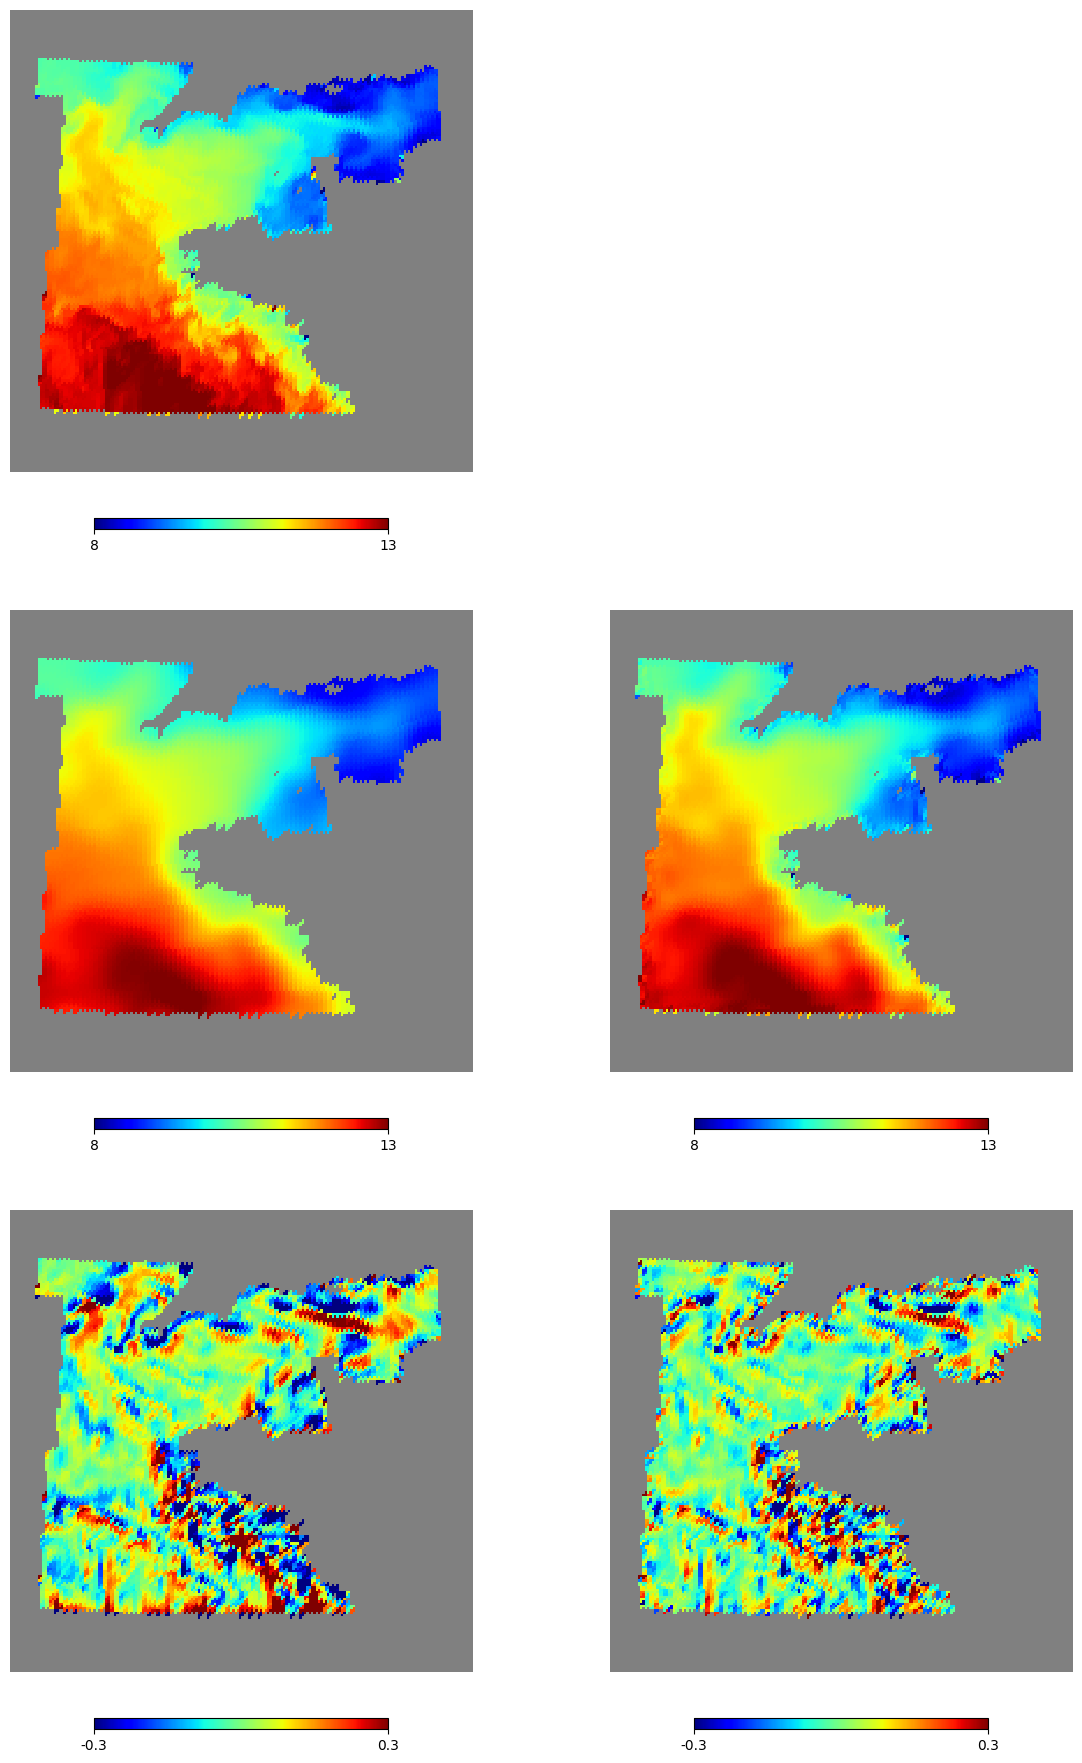

In [34]:
r=unet.eval(iref).detach()
plt.figure(figsize=(12,18))
plot_result(data,cell_ids,nside,hold=False,sub=(3,2,1),vmin=8,vmax=13)
plot_result(iref[0,0].cpu().numpy(),cell_ids,nside,hold=False,sub=(3,2,3),vmin=8,vmax=13)
plot_result(r[0,0].cpu().numpy(),cell_ids,nside,hold=False,sub=(3,2,4),vmin=8,vmax=13)
plot_result(data-iref[0,0].cpu().numpy(),cell_ids,nside,hold=False,sub=(3,2,5),vmin=-.3,vmax=.3)
plot_result(data-r[0,0].cpu().numpy(),cell_ids,nside,hold=False,sub=(3,2,6),vmin=-.3,vmax=.3)

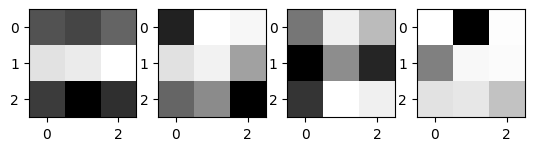

In [35]:
w1=cnn_weights[0:1*4*9].reshape(4,3,3)

for k in range(4):
    plt.subplot(1,4,1+k)
    plt.imshow(w1[k],cmap='Grays')